# **Modelling and Evaluation**

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---

## Import packages

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Change working directory

In [18]:
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Detection-in-Cherry-Leaves'

In [19]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [20]:
current_dir = os.getcwd()
current_dir

'/workspace'

---

## Set input directories

Set train, validation and test paths

In [6]:
my_data_dir = 'inputs/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [7]:
# Set output directory
version = 'v1'
file_path = f'outputs/{version}'

# Check if version folder already exists, if not, create one
if 'outputs' in os.listdir() and version in os.listdir('outputs'):
    print('Old version is already available, create a new version.')
else:
    os.makedirs(file_path)
    print(f'Output directory created at: {file_path}')

Old version is already available, create a new version.


## Set label names

In [8]:
# Set the labels
labels = os.listdir(train_path)
print('Labels for the images are:', labels)

Labels for the images are: ['healthy', 'powdery_mildew']


## Set image shape

In [9]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Image Distribution Across Train, Validation, and Test Sets

train - healthy: 1472 images
train - powdery_mildew: 1472 images
validation - healthy: 210 images
validation - powdery_mildew: 210 images
test - healthy: 422 images
test - powdery_mildew: 422 images


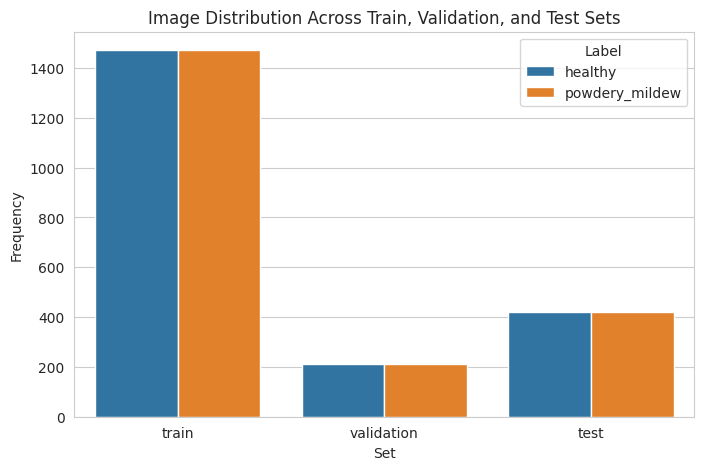

In [10]:
def count_images_per_set(data_dir, labels, output_dir, figsize=(8, 5)):
    """
    Counts the number of images in train, validation, and test sets for each label, 
    and creates a bar plot showing the distribution.
    
    Args:
    - data_dir: Directory where the datasets (train, validation, test) are stored.
    - labels: List of labels/categories in the dataset.
    - output_dir: Directory where the output plot will be saved.
    - figsize: Size of the plot figure.
    
    Returns:
    - A bar plot showing the image distribution in train, validation, and test sets.
    """
    # Initialize an empty DataFrame to store counts
    image_counts = pd.DataFrame([])
    
    # Iterate over train, validation, and test sets
    for dataset in ['train', 'validation', 'test']:
        for label in labels:
            # Count the number of images for each label in each set
            num_images = len(os.listdir(f"{data_dir}/{dataset}/{label}"))
            image_counts = image_counts.append(pd.Series({
                'Set': dataset,
                'Label': label,
                'Frequency': num_images
            }), ignore_index=True)
            
            # Print the count of images for each set and label
            print(f"{dataset} - {label}: {num_images} images")
    
    # Plot the distribution using Seaborn
    sns.set_style("whitegrid")
    plt.figure(figsize=figsize)
    sns.barplot(data=image_counts, x='Set', y='Frequency', hue='Label')
    plt.title("Image Distribution Across Train, Validation, and Test Sets")
    
    # Save the plot
    output_path = f"{output_dir}/image_distribution.png"
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.show()

# Example usage
count_images_per_set(data_dir=my_data_dir, labels=labels, output_dir=file_path, figsize=(8, 5))


---

## Data Augmentation

In [11]:
# Import required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for augmentation
def create_augmented_data_generator():
    """
    Creates an ImageDataGenerator object with specified augmentations for 
    training dataset. Applies rotation, shift, zoom, shear, and horizontal flip 
    to artificially increase the size and variability of the training set.

    Returns:
    --------
    ImageDataGenerator : A Keras ImageDataGenerator instance with augmentations.
    """
    augmented_data_gen = ImageDataGenerator(
        rotation_range=15,  
        width_shift_range=0.15,  
        height_shift_range=0.15,
        shear_range=0.2,  
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,  
        fill_mode='reflect',  
        rescale=1./255  
    )
    return augmented_data_gen

# Function to create datasets
def load_dataset(generator, path, image_size, batch_size, shuffle=True, mode='binary'):
    """
    Loads the dataset from the specified directory using a given ImageDataGenerator.

    Parameters:
    -----------
    generator : ImageDataGenerator
        The data generator to apply augmentations or preprocessing.
    path : str
        Path to the dataset directory.
    image_size : tuple
        Target size to resize the images (height, width).
    batch_size : int
        Number of images to process in each batch.
    shuffle : bool, optional
        Whether to shuffle the data before feeding it to the model (default is True).
    mode : str, optional
        Determines the type of classification ('binary' by default).

    Returns:
    --------
    DirectoryIterator : Keras DirectoryIterator
        An iterator over the dataset directory.
    """
    dataset = generator.flow_from_directory(
        path,
        target_size=image_size,
        color_mode='rgb',
        batch_size=batch_size,
        class_mode=mode,
        shuffle=shuffle
    )
    return dataset

image_size = (100, 100)  
batch_size = 32  

# Create generators
train_data_gen = create_augmented_data_generator()
val_test_data_gen = ImageDataGenerator(rescale=1./255)  # For validation and test, no augmentation needed

# Load datasets
train_set = load_dataset(train_data_gen, train_path, image_size, batch_size)
validation_set = load_dataset(val_test_data_gen, val_path, image_size, batch_size, shuffle=False)
test_set = load_dataset(val_test_data_gen, test_path, image_size, batch_size, shuffle=False)

# Print class indices for reference
print("Training set class indices:", train_set.class_indices)
print("Validation set class indices:", validation_set.class_indices)
print("Test set class indices:", test_set.class_indices)


Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.
Training set class indices: {'healthy': 0, 'powdery_mildew': 1}
Validation set class indices: {'healthy': 0, 'powdery_mildew': 1}
Test set class indices: {'healthy': 0, 'powdery_mildew': 1}


### Visualizing and Inspecting Augmented Images and Saving Class Indices

Displaying 3 sample images from the Training set:
Image batch shape: (32, 100, 100, 3)


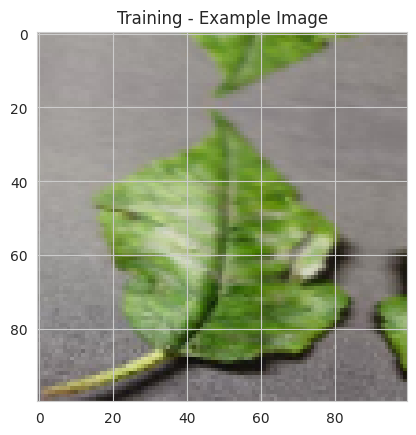

Image batch shape: (32, 100, 100, 3)


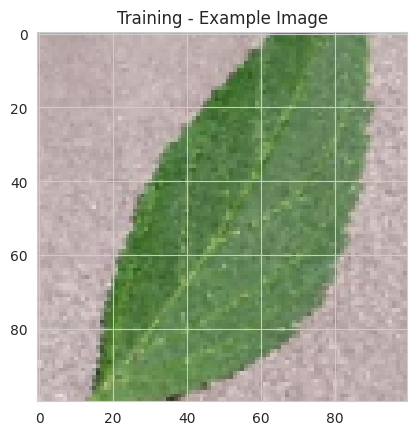

Image batch shape: (32, 100, 100, 3)


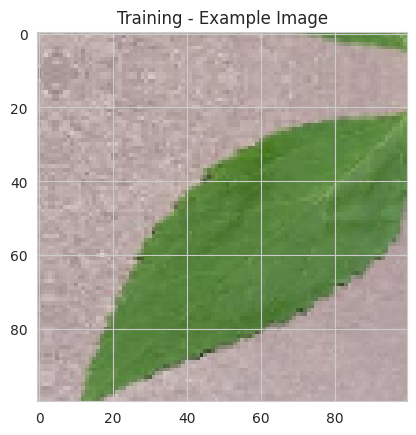

Displaying 3 sample images from the Validation set:
Image batch shape: (32, 100, 100, 3)


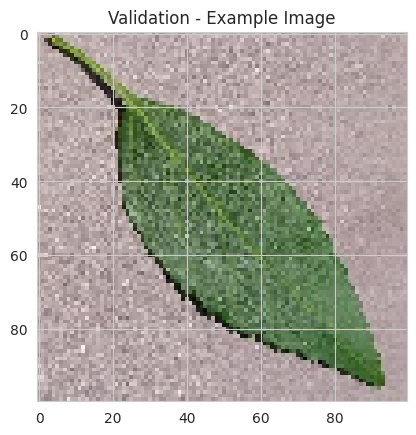

Image batch shape: (32, 100, 100, 3)


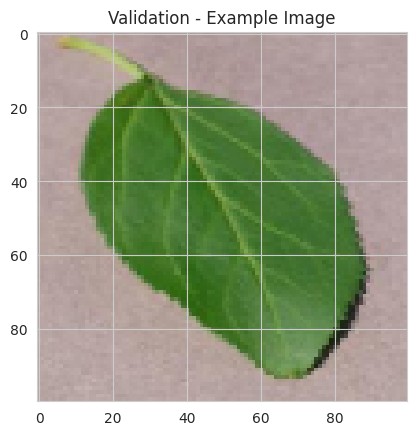

Image batch shape: (32, 100, 100, 3)


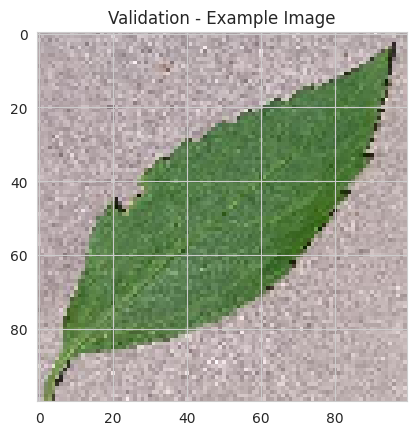

Displaying 3 sample images from the Test set:
Image batch shape: (32, 100, 100, 3)


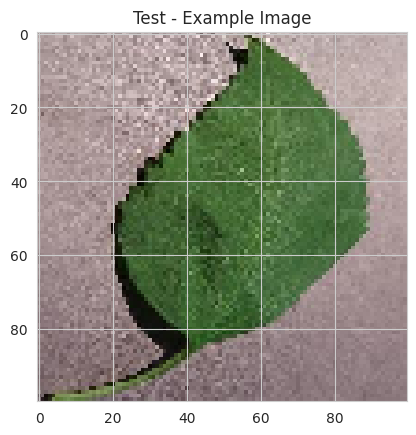

Image batch shape: (32, 100, 100, 3)


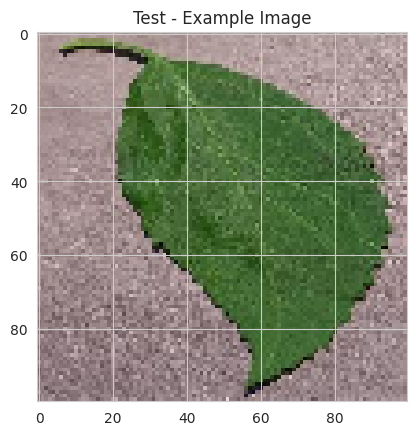

Image batch shape: (32, 100, 100, 3)


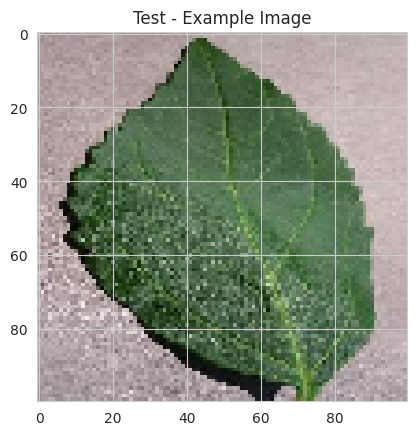

Class indices saved to outputs/class_indices.pkl


In [12]:
# Import necessary libraries
import matplotlib.pyplot as plt
import joblib

# Function to plot and display sample images from a dataset
def plot_sample_images(dataset, title, num_images=3):
    """
    Displays a set of images from a given dataset for visual inspection.
    
    Parameters:
    -----------
    dataset : DirectoryIterator
        The dataset from which to extract images (e.g., train_set, validation_set, test_set).
    title : str
        Title for the plot.
    num_images : int, optional
        The number of images to display (default is 3).
    """
    print(f"Displaying {num_images} sample images from the {title} set:")
    for _ in range(num_images):
        img_batch, label_batch = dataset.next()  # Get the next batch of images and labels
        print(f"Image batch shape: {img_batch.shape}")  # Print image shape for verification
        plt.imshow(img_batch[0])  # Show the first image in the batch
        plt.title(f"{title} - Example Image")  # Add a title to the plot
        plt.show()  # Display the image

# Plot augmented training images
plot_sample_images(train_set, "Training", num_images=3)

# Plot augmented validation images
plot_sample_images(validation_set, "Validation", num_images=3)

# Plot augmented test images
plot_sample_images(test_set, "Test", num_images=3)

# Function to save class indices
def save_class_indices(indices, file_path):
    """
    Saves class indices (e.g., {'healthy': 0, 'powdery_mildew': 1}) to a .pkl file for future reference.
    
    Parameters:
    -----------
    indices : dict
        A dictionary containing the class labels and their corresponding indices.
    file_path : str
        The directory path where the file will be saved.
    """
    joblib.dump(value=indices, filename=f"{file_path}/class_indices.pkl")
    print(f"Class indices saved to {file_path}/class_indices.pkl")

# Save class indices for reference
save_class_indices(train_set.class_indices, file_path="outputs") 


---

## Model creation

* Model

In [13]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

def build_cnn_model():
    """
    Builds and compiles a Convolutional Neural Network (CNN) model for binary image classification.
    
    Returns:
    --------
    model : keras.Sequential
        Compiled CNN model ready for training.
    """
    # Initialize Sequential model
    model = Sequential()

    # Add first convolutional block
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add third convolutional block 
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add fully connected layer after flattening
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))

    # Add dropout to prevent overfitting
    model.add(Dropout(0.4)) 

    # Add output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model using Adam optimizer and binary crossentropy
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


* Model Summary

In [14]:
build_cnn_model().summary()

2024-09-24 15:04:17.953529: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0

* Early stopping

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

* Fit model for model training

In [16]:
model = build_cnn_model()
# Train the model
model.fit(
    train_set,
    epochs=30,  # Increased number of epochs
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=validation_set,
    callbacks=[early_stopping],
    verbose=1
)


2024-09-24 15:12:53.851352: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


InvalidArgumentError:  Input to reshape is a tensor with 589824 values, but the requested shape requires a multiple of 131072
	 [[node sequential_1/flatten_1/Reshape (defined at tmp/ipykernel_1669/2227686328.py:3) ]] [Op:__inference_train_function_1091]

Function call stack:
train_function


### Save model

In [ ]:
model.save('outputs/v1/mildew_model_v1.h5')